# Predicting Lung Disease using Convolutional Neural Networks

Name : Suraj Padmanabh Shet

Aim : To predict wheater the particular x-ray of the patient has lung disease i.e 
    in particular pneumonia or not

## Importing the libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
# we will create a generic code which can be used for other base models as well
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from glob import glob
from keras.layers import GlobalAveragePooling2D

* as we are going to load the images and the images have different sizes..we have to make
sure to have generic size so which we can feed it to neural network
* https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05

# Transfer Learning

In [2]:
# resize the images
IMAGE_SIZE = [224, 224]
train_path = 'Datasets/train'
test_path = 'Datasets/test'


## VGG16
Presented in 2014, VGG16 has a very simple and classical architecture, with blocks of 2 or 3 convolutional layers followed by a pooling layer, plus a final dense network composed of 2 hidden layers (of 4096 nodes each) and one output layer (of 1000 nodes). Only 3x3 filters are used

* Import the Vgg 16 library as our base model as shown below and add preprocessing layer to the front of VGG
    Here we will be using imagenet weights
* We are transfer learning over here
* [3] indicates we have 3 channels over there
* include_top = False as VGG16 which is trained on imagenet dataset has 1000 classes but here we want to predict if our image has pneumonia or not so we are taking out the last layer and then we will place our class which has 2 classes
* add image size and remove last layer to do binary classification(i.e imagenet contains about 1000 classes but here we have only two: neumonia or no neumonia

In [3]:
vgg = VGG16(include_top=False, weights='imagenet',input_shape=IMAGE_SIZE + [3])

* Specify i dont want to train existing weight over here

In [4]:
for layer in vgg.layers:
    layer.trainable = False

* for getting number of output classes in order to know how many output to expect
use glob

In [5]:
folders = glob('Datasets/train/*')

In [6]:
folders

['Datasets/train\\NORMAL', 'Datasets/train\\PNEUMONIA']

In [7]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout


In [9]:
vgg_final = Sequential([vgg,
                        #GlobalAveragePooling2D(),
                        #Dense(units = 512, activation = 'relu'),
                        #BatchNormalization(),
                        #Dropout(0.6),
                        #Dense(units = 128, activation = 'relu'),
                        #BatchNormalization(),
                        #Dropout(0.4),
                        Flatten(),
                        # Dense(units = 12, activation = 'relu'),
                        # BatchNormalization(),
                        # Dropout(0.3),
                        Dense(2, activation = 'sigmoid')

])

In [10]:
vgg_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
METRICS = ['accuracy'], tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')


## Compiling the model

In [12]:
vgg_final.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=METRICS)

* Use the Image Data Generator to import the images from the dataset
* this is going to help us in augment the image because not all the time all images are in right form so use image generator 

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)

* Make sure you provide the same target size as initialied for the image size

In [14]:
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')


Found 5216 images belonging to 2 classes.


In [15]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                           target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 624 images belonging to 2 classes.


## Fitting the model

In [16]:
r = vgg_final.fit_generator(training_set,
                            validation_data=test_set,
                            epochs=20,
                            steps_per_epoch = len(training_set),
                            validation_steps = len(test_set)
)

C:\Users\Asus\AppData\Local\Temp\ipykernel_169736\3258044409.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = vgg_final.fit_generator(training_set,


Epoch 1/20
163/163 [==============================] - 1550s 10s/step - loss: 0.1798 - accuracy: 0.9317 - precision: 0.9509 - recall: 0.8992 - val_loss: 0.2458 - val_accuracy: 0.9119 - val_precision: 0.9312 - val_recall: 0.8894
Epoch 2/20
163/163 [==============================] - 1371s 8s/step - loss: 0.1147 - accuracy: 0.9588 - precision: 0.9680 - recall: 0.9398 - val_loss: 0.3161 - val_accuracy: 0.9022 - val_precision: 0.9185 - val_recall: 0.8670
Epoch 3/20
163/163 [==============================] - 1369s 8s/step - loss: 0.0855 - accuracy: 0.9686 - precision: 0.9767 - recall: 0.9546 - val_loss: 0.2433 - val_accuracy: 0.9183 - val_precision: 0.9331 - val_recall: 0.8942
Epoch 4/20
163/163 [==============================] - 1370s 8s/step - loss: 0.0857 - accuracy: 0.9651 - precision: 0.9764 - recall: 0.9534 - val_loss: 0.2560 - val_accuracy: 0.9119 - val_precision: 0.9285 - val_recall: 0.8942
Epoch 5/20
163/163 [==============================] - 1371s 8s/step - loss: 0.0994 - accuracy: 

In [17]:
# r = vgg_final.fit_generator(training_set,
#                             validation_data=test_set,
#                             epochs=5,
#                             steps_per_epoch = len(training_set),
#                             validation_steps = len(test_set)
# )

## Plot the loss and the accuracy

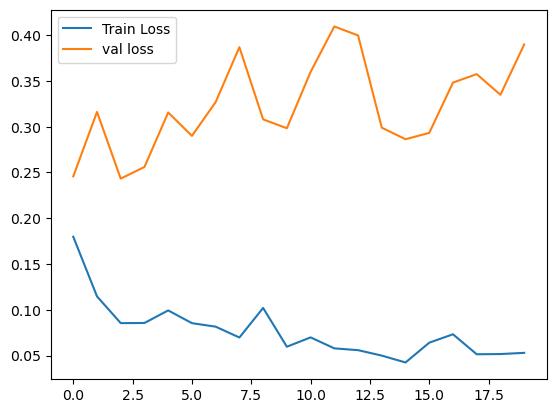

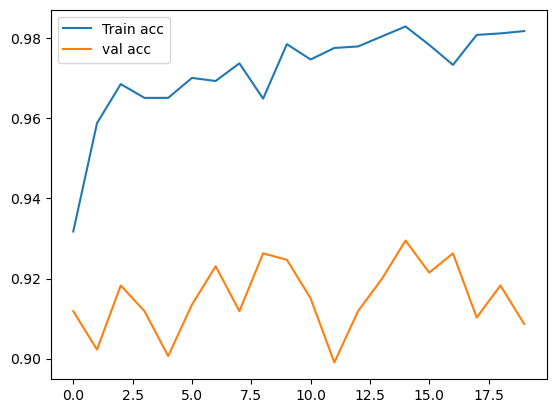

<Figure size 640x480 with 0 Axes>

In [18]:
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('lossval_loss')

plt.plot(r.history['accuracy'], label='Train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Accval_acc')

## Save it as h5 file

In [19]:
from keras.models import load_model
vgg_final.save('model_vgg16.h5')

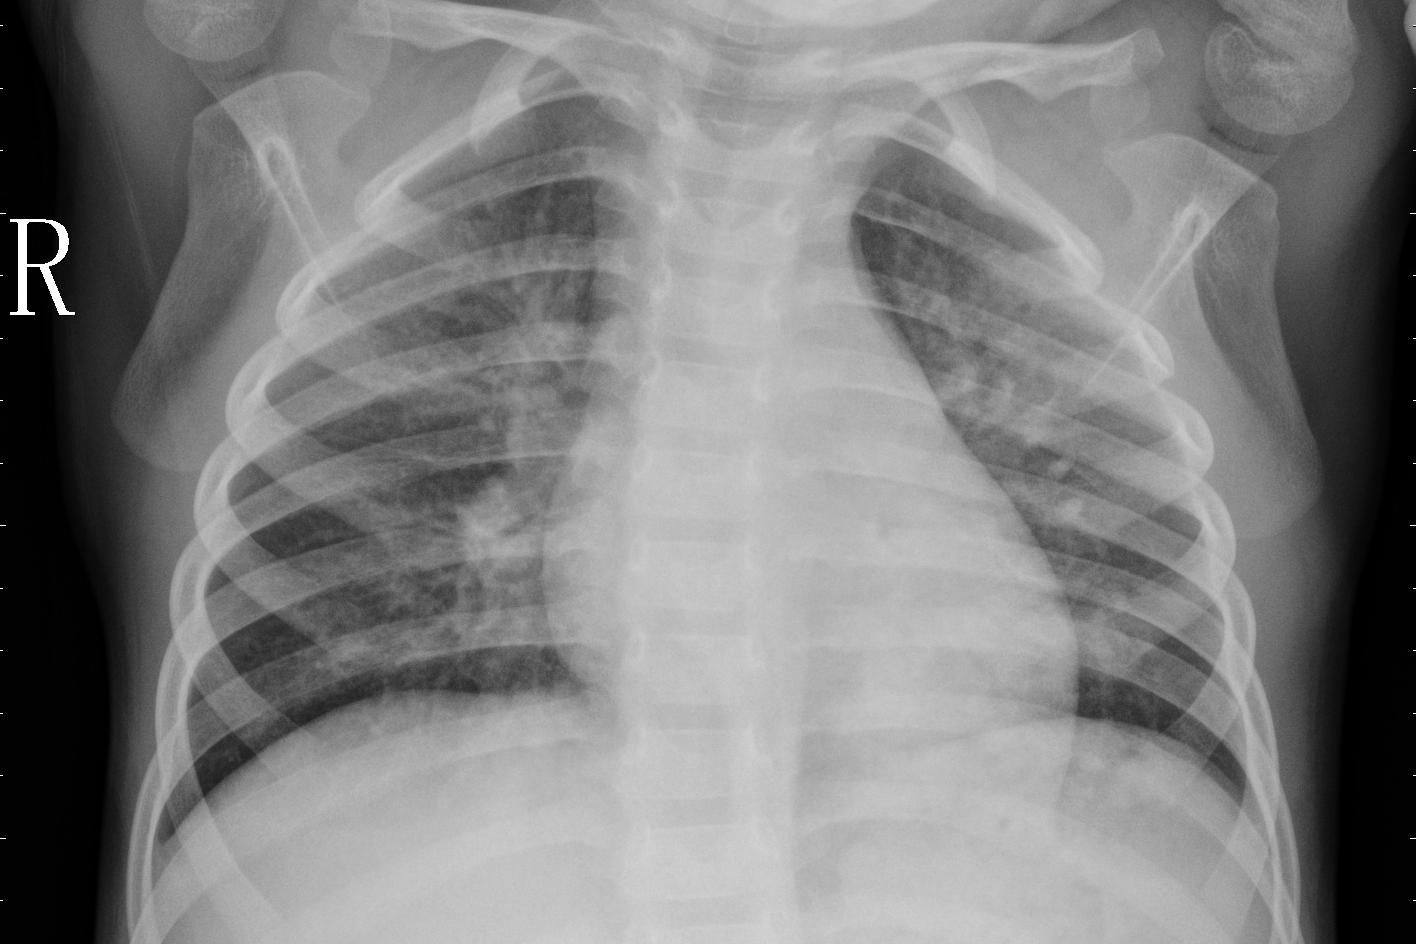

In [20]:
from IPython.display import display
from PIL import Image


NeumonialPath="Datasets/val/PNEUMONIA/person1949_bacteria_4880.jpeg"
# NormalPath = "Datasets/val/NORMAL/NORMAL2-IM-1431-0001.jpeg"
display(Image.open(NeumonialPath))

In [21]:
from tensorflow.keras.models import load_model
import numpy as np
# from keras.preprocessing import image


model = load_model('model_vgg16.h5')

img = tf.keras.utils.load_img(NeumonialPath,target_size=(224, 224))

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes)
if classes[0][0] > classes[0][1]:
    print('X-Ray image is NORMAL')
else:
    print('X-Ray image is Having NEUMONIA')

1/1 [==============================] - 1s 623ms/step
[[0. 1.]]
X-Ray image is Having NEUMONIAL


## INCEPTION NET

* Also known as GoogleNet, this architecture presents sub-networks called inception modules, which allows fast training computing, complex patterns detection, and optimal use of parameters

In [49]:
from tensorflow.keras.applications import InceptionV3

In [50]:
IMAGE_SIZE = [224, 224]
train_path = 'Datasets/train'
test_path = 'Datasets/test'
inception_base_model = InceptionV3(input_shape = IMAGE_SIZE + [3], 
                                   include_top = False,
                                  weights = 'imagenet')

In [51]:
for layer in inception_base_model.layers:
    layer.trainable = False

In [52]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential


inception_model = Sequential([
    
    inception_base_model,
    GlobalAveragePooling2D(),
    Dense(36, activation = 'relu'),
    Dropout(0.3),
    Dense(2, activation = 'sigmoid')
    
])

In [53]:
inception_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 36)                73764     
                                                                 
 dropout_13 (Dropout)        (None, 36)                0         
                                                                 
 dense_27 (Dense)            (None, 2)                 74        
                                                                 
Total params: 21,876,622
Trainable params: 73,838
Non-trainable params: 21,802,784
____________________________________

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
METRICS = ['accuracy']


## Compiling the model

In [55]:
inception_model.compile(optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics= ['accuracy']

)

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [59]:
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')


Found 5216 images belonging to 2 classes.


In [60]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                           target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 624 images belonging to 2 classes.


## Fitting the model

In [62]:
r = inception_model.fit_generator(training_set,
                            validation_data=test_set,
                            epochs=10,
                            steps_per_epoch = len(training_set),
                            validation_steps = len(test_set)
)

C:\Users\Asus\AppData\Local\Temp\ipykernel_75884\1876768729.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = inception_model.fit_generator(training_set,


Epoch 1/10
163/163 [==============================] - 325s 2s/step - loss: 0.2989 - accuracy: 0.8731 - val_loss: 0.4847 - val_accuracy: 0.7949
Epoch 2/10
163/163 [==============================] - 334s 2s/step - loss: 0.2008 - accuracy: 0.9197 - val_loss: 0.3995 - val_accuracy: 0.8333
Epoch 3/10
163/163 [==============================] - 357s 2s/step - loss: 0.1833 - accuracy: 0.9316 - val_loss: 0.3840 - val_accuracy: 0.8446
Epoch 4/10
163/163 [==============================] - 357s 2s/step - loss: 0.1844 - accuracy: 0.9302 - val_loss: 0.5866 - val_accuracy: 0.8173
Epoch 5/10
163/163 [==============================] - 359s 2s/step - loss: 0.1719 - accuracy: 0.9337 - val_loss: 0.3939 - val_accuracy: 0.8446
Epoch 6/10
163/163 [==============================] - 353s 2s/step - loss: 0.1646 - accuracy: 0.9362 - val_loss: 0.5745 - val_accuracy: 0.8189
Epoch 7/10
163/163 [==============================] - 358s 2s/step - loss: 0.1565 - accuracy: 0.9410 - val_loss: 0.4777 - val_accuracy: 0.8349

## Plot the loss and the accuracy

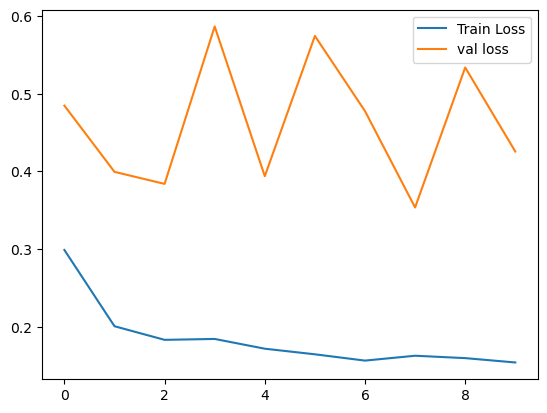

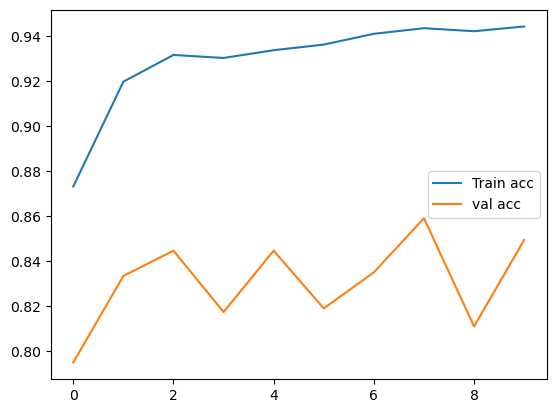

<Figure size 640x480 with 0 Axes>

In [64]:
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('lossval_loss')

plt.plot(r.history['accuracy'], label='Train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Accval_acc')

## Save it as h5 file

In [67]:
from keras.models import load_model
inception_model.save('model_inception.h5')

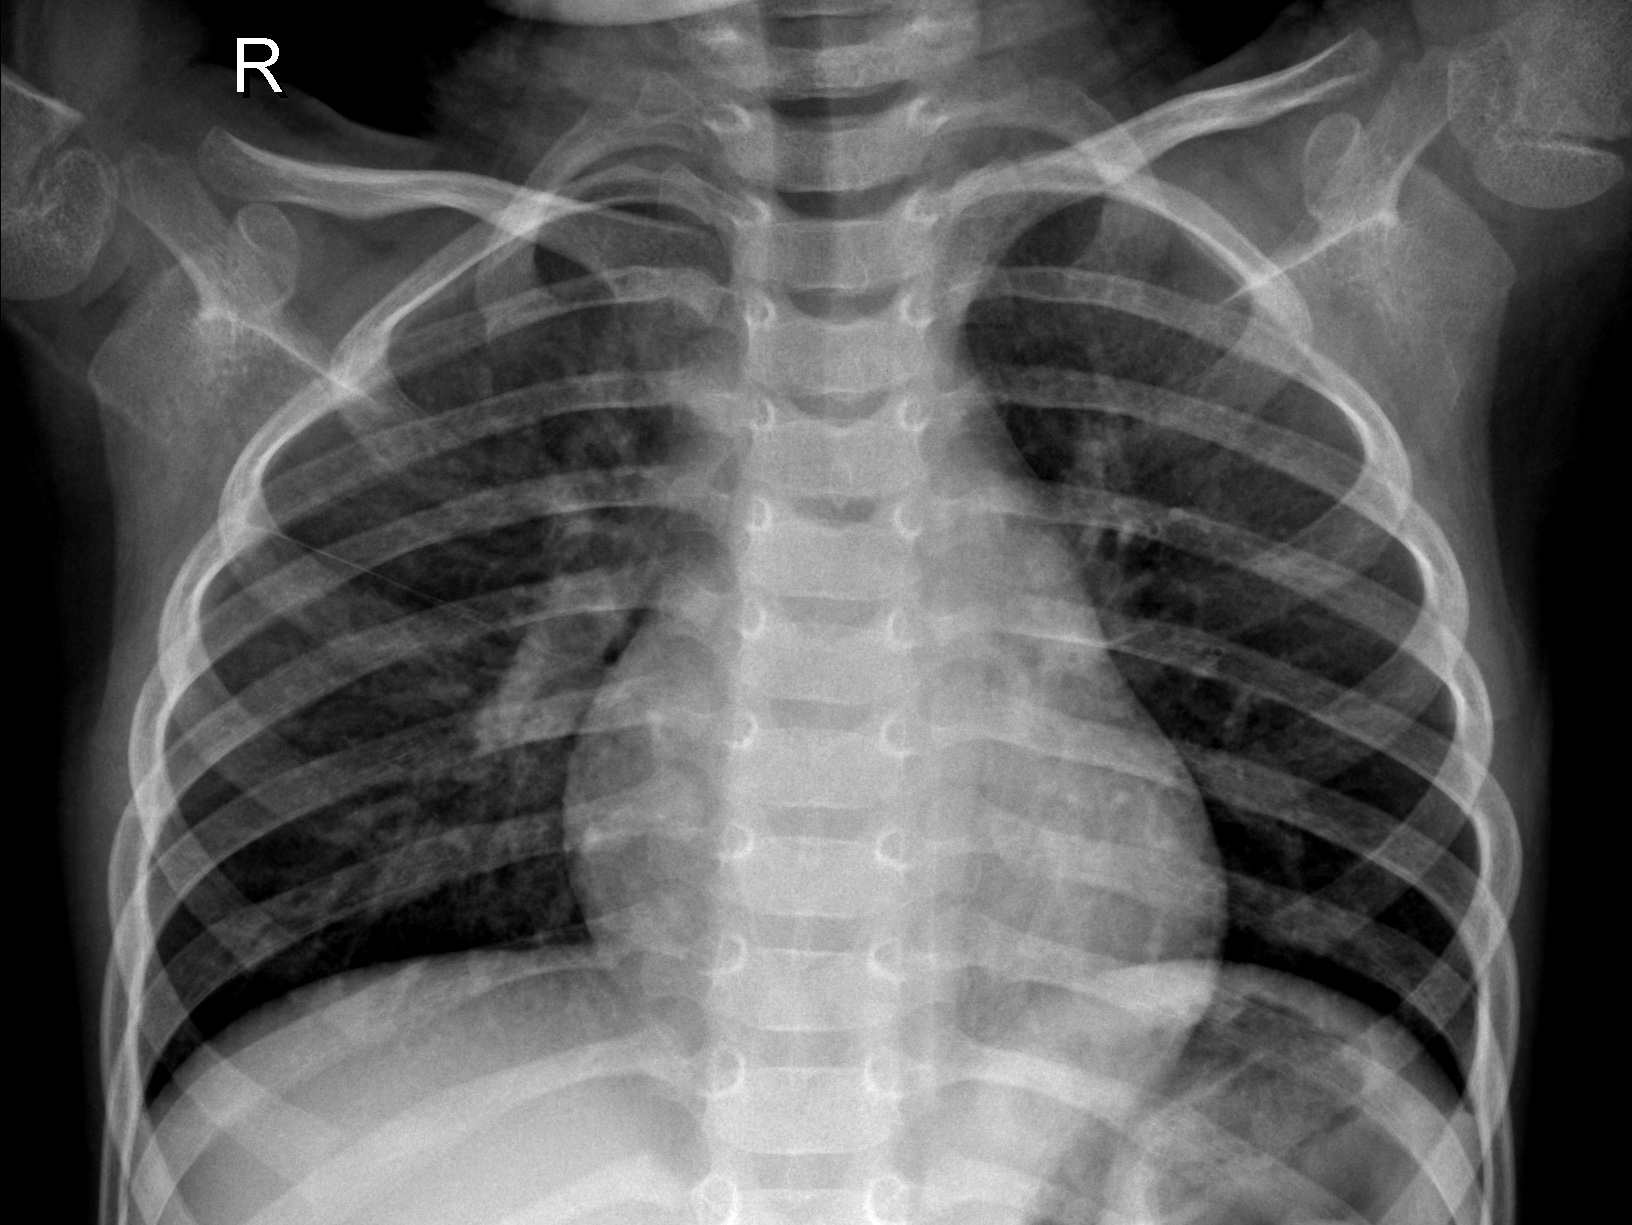

In [69]:
from IPython.display import display
from PIL import Image


#NeumonialPath="Datasets/val/PNEUMONIA/person1949_bacteria_4880.jpeg"
NormalPath = "Datasets/val/NORMAL/NORMAL2-IM-1440-0001.jpeg"
display(Image.open(NormalPath))

In [74]:
from tensorflow.keras.models import load_model
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

model = load_model('model_inception.h5')

img = tf.keras.utils.load_img(NormalPath,target_size=(224, 224))

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes)
if classes[0][0] > classes[0][1]:
    print('X-Ray image is NORMAL')
else:
    print('X-Ray image is Having NEUMONIA')

1/1 [==============================] - 2s 2s/step
[[0.9826518 0.841237 ]]
X-Ray image is NORMAL


# ALEX NET

* AlexNet was designed by Hinton, winner of the 2012 ImageNet competition, and his student Alex Krizhevsky. It was also after that year that more and deeper neural networks were proposed, such as the excellent vgg, GoogleLeNet. Its official data model has an accuracy rate of 57.1% and top 1-5 reaches 80.2%. This is already quite outstanding for traditional machine learning classification algorithms.

## Importing necessary libraries

In [95]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import numpy as np

In [96]:
# (3) Create a sequential model
alexnetmodel = Sequential()

# 1st Convolutional Layer
alexnetmodel.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
alexnetmodel.add(Activation('relu'))
# Pooling 
alexnetmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
alexnetmodel.add(BatchNormalization())

# 2nd Convolutional Layer
alexnetmodel.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
alexnetmodel.add(Activation('relu'))
# Pooling
alexnetmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# 3rd Convolutional Layer
alexnetmodel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnetmodel.add(Activation('relu'))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# 4th Convolutional Layer
alexnetmodel.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnetmodel.add(Activation('relu'))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# 5th Convolutional Layer
alexnetmodel.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
alexnetmodel.add(Activation('relu'))
# Pooling
alexnetmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# Passing it to a dense layer
alexnetmodel.add(Flatten())
# 1st Dense Layer
alexnetmodel.add(Dense(4096, input_shape=(224*224*3,)))
alexnetmodel.add(Activation('relu'))
# Add Dropout to prevent overfitting
alexnetmodel.add(Dropout(0.4))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# 2nd Dense Layer
alexnetmodel.add(Dense(4096))
alexnetmodel.add(Activation('relu'))
# Add Dropout
alexnetmodel.add(Dropout(0.4))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# 3rd Dense Layer
alexnetmodel.add(Dense(1000))
alexnetmodel.add(Activation('relu'))
# Add Dropout
alexnetmodel.add(Dropout(0.4))
# Batch Normalisation
alexnetmodel.add(BatchNormalization())

# Output Layer
alexnetmodel.add(Dense(2))
alexnetmodel.add(Activation('sigmoid'))


In [97]:
alexnetmodel.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_485 (Conv2D)         (None, 54, 54, 96)        34944     
                                                                 
 activation_497 (Activation)  (None, 54, 54, 96)       0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_495 (Ba  (None, 27, 27, 96)       384       
 tchNormalization)                                               
                                                                 
 conv2d_486 (Conv2D)         (None, 17, 17, 256)       2973952   
                                                                 
 activation_498 (Activation)  (None, 17, 17, 256)    

## Compiling the model

In [98]:
alexnetmodel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [99]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [100]:
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')


Found 5216 images belonging to 2 classes.


In [101]:
test_set = test_datagen.flow_from_directory('Datasets/test',
                                           target_size = (224,224),
                                                batch_size = 32,
                                                class_mode = 'categorical')

Found 624 images belonging to 2 classes.


## Fitting the model

In [102]:
h = alexnetmodel.fit_generator(training_set,
                              validation_data = test_set,
                              epochs = 10,
                              steps_per_epoch = len(training_set),
                              validation_steps = len(test_set))

C:\Users\Asus\AppData\Local\Temp\ipykernel_75884\2601786902.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = alexnetmodel.fit_generator(training_set,


Epoch 1/10
163/163 [==============================] - 370s 2s/step - loss: 0.5353 - accuracy: 0.8198 - val_loss: 0.6273 - val_accuracy: 0.7308
Epoch 2/10
163/163 [==============================] - 377s 2s/step - loss: 0.2898 - accuracy: 0.8917 - val_loss: 0.8158 - val_accuracy: 0.7372
Epoch 3/10
163/163 [==============================] - 371s 2s/step - loss: 0.2406 - accuracy: 0.9028 - val_loss: 1.6212 - val_accuracy: 0.6779
Epoch 4/10
163/163 [==============================] - 376s 2s/step - loss: 0.2097 - accuracy: 0.9187 - val_loss: 0.7018 - val_accuracy: 0.7708
Epoch 5/10
163/163 [==============================] - 375s 2s/step - loss: 0.2020 - accuracy: 0.9193 - val_loss: 0.5240 - val_accuracy: 0.7804
Epoch 6/10
163/163 [==============================] - 418s 3s/step - loss: 0.1979 - accuracy: 0.9227 - val_loss: 0.3234 - val_accuracy: 0.8686
Epoch 7/10
163/163 [==============================] - 391s 2s/step - loss: 0.1967 - accuracy: 0.9250 - val_loss: 1.5931 - val_accuracy: 0.6250

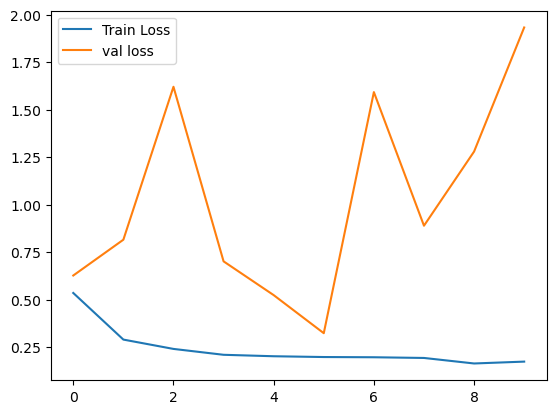

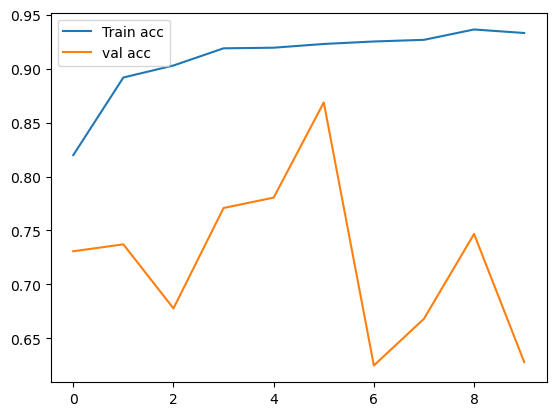

<Figure size 640x480 with 0 Axes>

In [103]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('lossval_loss')

plt.plot(h.history['accuracy'], label='Train acc')
plt.plot(h.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Accval_acc')

* This performs somewhat better than the previous ones
* maybe if we can have L2 regularization along side dropout we can reduce 
overfitting and difference of training and validation


## Save it as h5 file

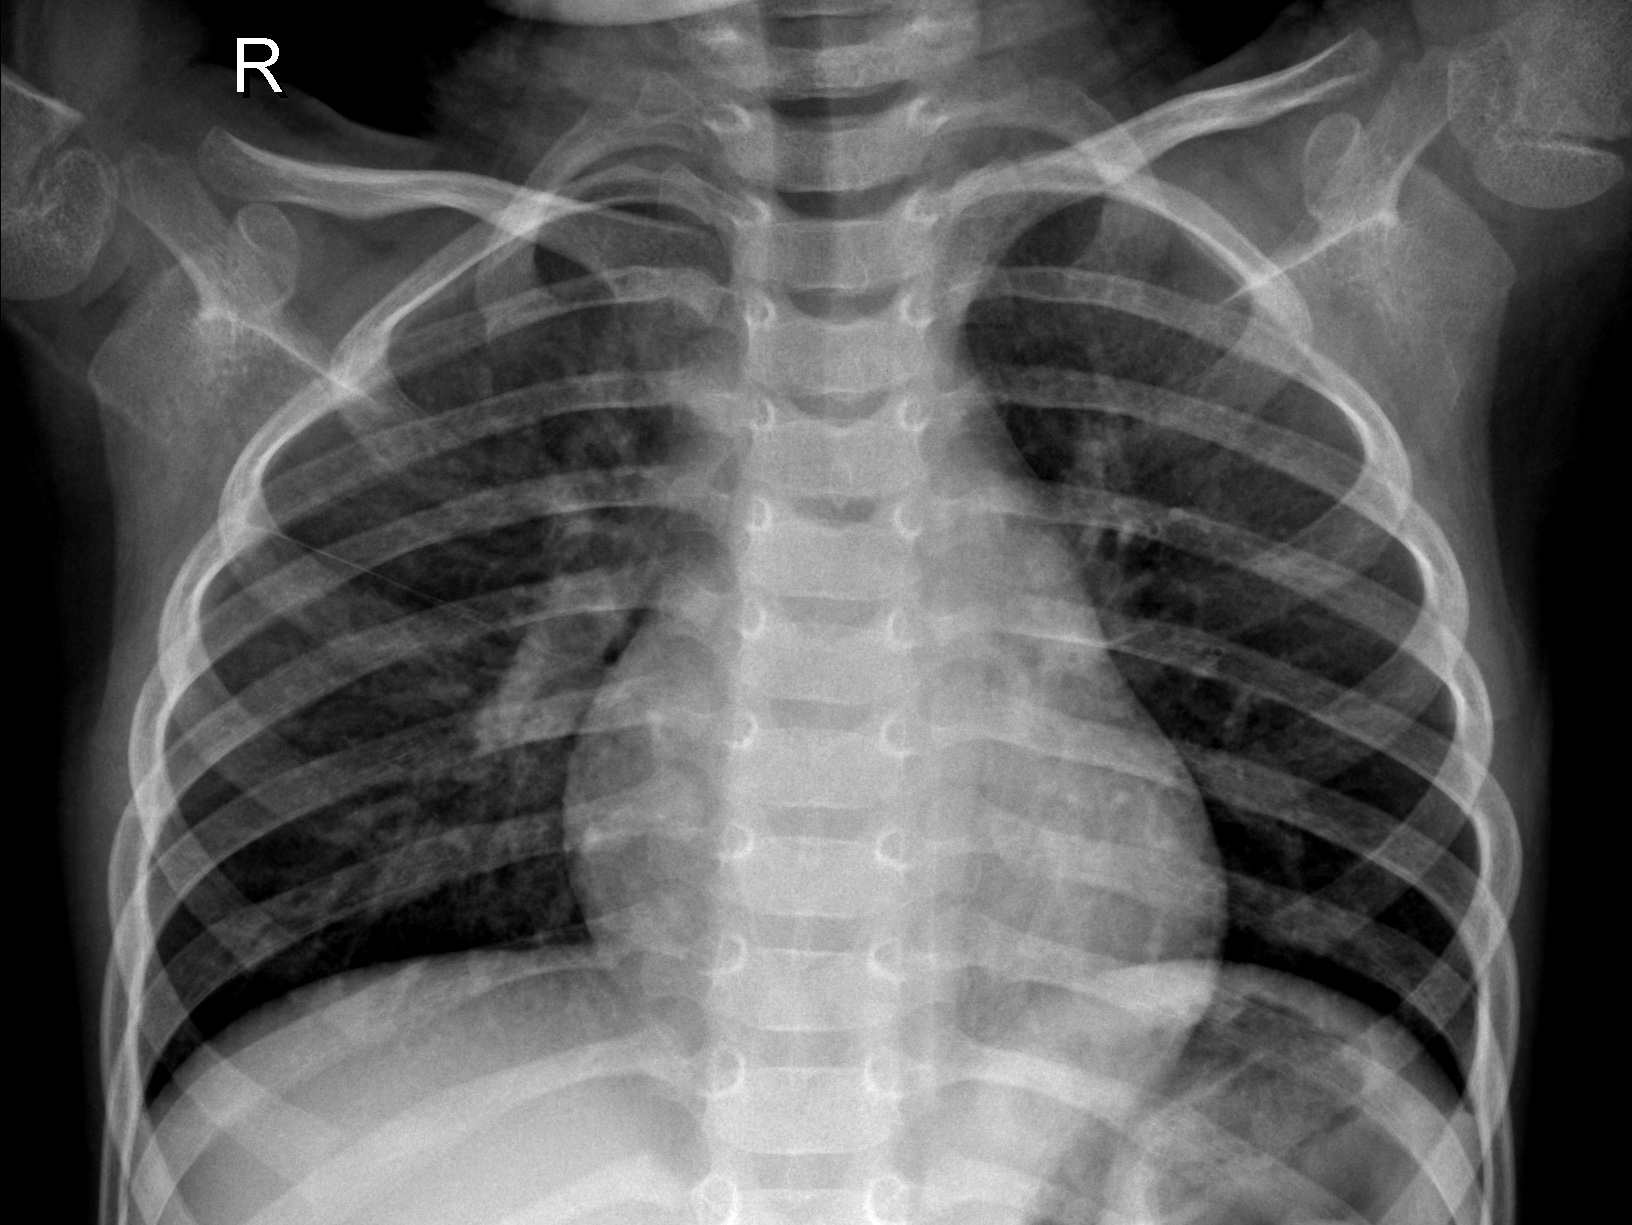

In [107]:
from IPython.display import display
from PIL import Image


NeumonialPath1 = "Datasets/val/PNEUMONIA/person1949_bacteria_4876.jpeg"
NeumonialPath2 = "Datasets/val/PNEUMONIA/person1949_bacteria_4876.jpeg"
NormalPath1 = "Datasets/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
NormalPath2 = "Datasets/val/NORMAL/NORMAL2-IM-1427-0001.jpeg"
display(Image.open(NeumonialPath1))

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

model = load_model('model_inception.h5')

img = tf.keras.utils.load_img(NeumonialPath1,target_size=(224, 224))

x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes)
if classes[0][0] > classes[0][1]:
    print('X-Ray image is NORMAL')
else:
    print('X-Ray image is Having NEUMONIA')